## 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

## Setup and Import Libraries

In [1]:
import os
from typing import Annotated, TypedDict, Sequence
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from dotenv import load_dotenv


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embedding = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Create Retriever Tool

In [5]:
document = WebBaseLoader(
    "https://lilianweng.github.io/posts/2023-06-23-agent/"
).load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
)
chunks = text_splitter.split_documents(documents=document)

In [6]:
vector_store = FAISS.from_documents(
    documents=chunks, embedding=embedding
)
retriever = vector_store.as_retriever()

In [7]:
retriever.invoke(input="what are autonomous agents")

[Document(id='facb77bc-9bd9-47ef-9ca5-a21c12d594fe', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [8]:
def retriever_tool(query: str) -> str:
    print("Using RAG Retriever Tool")
    documents = retriever.invoke(input=query)
    return "\n".join([document.page_content for document in documents])

In [9]:
retriever_tool(query="what are autonomous agents")

Using RAG Retriever Tool


'Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\nOr\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate P

In [10]:
retriever_tool = Tool(
    name="RAG_Retriever", 
    description="Use this tool to fetch relevant information",
    func=retriever_tool
)

retriever_tool

Tool(name='RAG_Retriever', description='Use this tool to fetch relevant information', func=<function retriever_tool at 0x000002047839E700>)

In [11]:
print(retriever_tool.name)

RAG_Retriever


## Creating Wikipedia Tool

In [12]:
wikipedia_api_wrapper = WikipediaAPIWrapper()
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)
wikipedia_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\SAAD TARIQ\\github_repositories\\RAG-Bootcamp\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [13]:
print(wikipedia_tool.name)

wikipedia


## Create ReAct Agent

In [14]:
tools = [retriever_tool, wikipedia_tool]

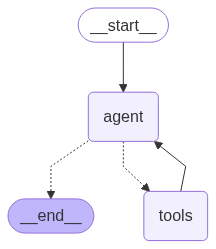

In [15]:
react_node = create_react_agent(
    model=llm, tools=tools
)

react_node

## Build Graph

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

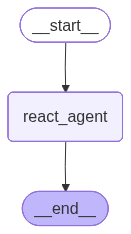

In [17]:
graph = StateGraph(AgentState)

# Add Nodes
graph.add_node(node="react_agent", action=react_node)

# Set Entry Point
graph.set_entry_point(key="react_agent")

# Add Edges
graph.add_edge(start_key="react_agent", end_key=END)

# Compile Graph
compiled_graph = graph.compile()

# Display Graph
compiled_graph

In [18]:
user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"


state = {"messages": [HumanMessage(content=user_query)]}
result = compiled_graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

Using RAG Retriever Tool

✅ Final Answer:
 ### Agent Loop
The concept of an "agent loop" involves utilizing autonomous agents that can independently perform complex tasks. These agents can continually learn and adapt, thereby improving their performance over time. The process involves feeding learning history back into the model to facilitate continuous improvement. This approach is seen in areas such as scientific discovery, where agents perform tasks like internet browsing, code execution, and using robotics APIs to autonomously design, plan, and perform complex experiments.

### Autonomous Agents (According to Wikipedia)
An autonomous agent is an artificial intelligence (AI) system capable of performing complex tasks independently. They are considered a specialized type of intelligent agent, which perceive their environment and act autonomously to achieve specific goals. These agents can range from simple systems like thermostats to complex systems capable of independent thinking, p